## 手写数字识别
### 1. 导入模块

In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
#import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
%matplotlib inline

In [4]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

True
True
cuda


### 2. 导入数据和处理数据

In [5]:
train_df = pd.read_csv("digit-recognizer/train.csv")
test_df = pd.read_csv("digit-recognizer/test.csv")

In [6]:
train_df.iloc[:,1:].values.astype('float32')[0].shape

(784,)

In [7]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

# 划分数据集和验证集
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, 
                                                                     stratify=train_labels, random_state=42,
                                                                     test_size=0.2
                                                                     )

In [8]:
train_images = train_images.reshape((train_images.shape[0], 28, 28))
val_images = val_images.reshape((val_images.shape[0], 28, 28))
test_images = test_images.reshape((test_images.shape[0], 28, 28))


(33600, 28, 28)


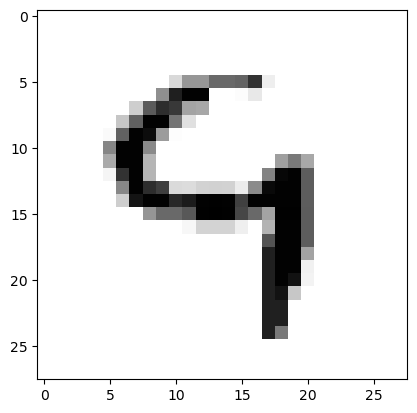

In [9]:
print(train_images.shape)

plt.imshow(train_images[10],cmap=plt.cm.binary)

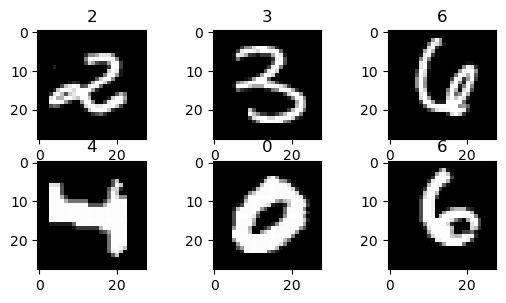

In [13]:
for i in range(6):
    plt.subplot(330+(i+1))
    plt.imshow(train_images[i].squeeze(),cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

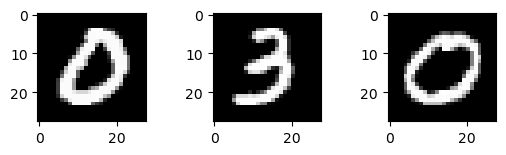

In [14]:
for i in range(6,9):
    plt.subplot(330+(i+1))
    plt.imshow(test_images[i].squeeze(), cmap=plt.get_cmap('gray'))

In [16]:
# 归一化 0.0~1.0
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

test_images_tensor = torch.tensor(test_images)/255.0

In [19]:
train_loader = DataLoader(train_tensor,batch_size=16,num_workers=2,shuffle=True)
val_loader = DataLoader(val_tensor,batch_size=16,num_workers=2,shuffle=True)
test_loader = DataLoader(test_images_tensor,batch_size=16,num_workers=2,shuffle=True)

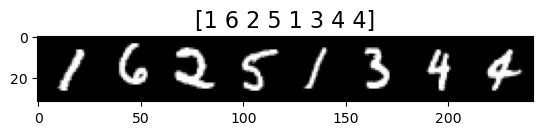

In [21]:
# 查看train_loader里的数据
for batch_idx, (data, target) in enumerate(train_loader):
    img_grid = make_grid(data[0:8,].unsqueeze(1),nrow=8)
    img_traget_labels = target[0:8,].numpy()
    break

plt.imshow(img_grid.numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize']=(10,2)
plt.title(img_traget_labels,size=16)
plt.show()

### 3. 构建CNN模型

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )

        self.liner_block=nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128*7*7,128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64,10)
        )

    def forward(self,x):
        x=self.conv_block(x)
        x=x.view(x.size(0),-1)
        x=self.liner_block(x)
        return x


In [23]:
conv_model = Net()
conv_model

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (liner_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

### 4. 优化器设置

In [28]:
optimizer = optim.Adam(params=conv_model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    conv_model = conv_model.cuda()
    criterion = criterion.cuda()

In [39]:
def train_model(num_epoch):
    conv_model.train()
    exp_lr_scheduler.step()

    for batch_idx,(data, target) in enumerate(train_loader):
        data=data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data=data.cuda()
            target=target.cuda()
        
        optimizer.zero_grad()
        output = conv_model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1)%100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx+1)*len(data), len(train_loader.dataset),
                100. * (batch_idx+1)/len(train_loader), loss.item())
            )

def evaluate(data_loader):
    conv_model.eval()
    loss = 0
    correct = 0

    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data=data.cuda()
            target=target.cuda()

        output = conv_model(data)
        loss += F.nll_loss(output, target, size_average=False).data.item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(data_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)
))

In [40]:
num_epochs = 10

for n in range(num_epochs):
    train_model(n)
    evaluate(val_loader)

Train Epoch: 0 [1600/33600 (5%)]	Loss: 0.029931
Train Epoch: 0 [3200/33600 (10%)]	Loss: 0.158632
Train Epoch: 0 [4800/33600 (14%)]	Loss: 0.029843
Train Epoch: 0 [6400/33600 (19%)]	Loss: 0.013549
Train Epoch: 0 [8000/33600 (24%)]	Loss: 0.033292
Train Epoch: 0 [9600/33600 (29%)]	Loss: 0.171332
Train Epoch: 0 [11200/33600 (33%)]	Loss: 0.020723
Train Epoch: 0 [12800/33600 (38%)]	Loss: 0.112330
Train Epoch: 0 [14400/33600 (43%)]	Loss: 0.008459
Train Epoch: 0 [16000/33600 (48%)]	Loss: 0.115110
Train Epoch: 0 [17600/33600 (52%)]	Loss: 0.129915
Train Epoch: 0 [19200/33600 (57%)]	Loss: 0.215343
Train Epoch: 0 [20800/33600 (62%)]	Loss: 0.003336
Train Epoch: 0 [22400/33600 (67%)]	Loss: 0.141484
Train Epoch: 0 [24000/33600 (71%)]	Loss: 0.032134
Train Epoch: 0 [25600/33600 (76%)]	Loss: 0.002617
Train Epoch: 0 [27200/33600 (81%)]	Loss: 0.056962
Train Epoch: 0 [28800/33600 (86%)]	Loss: 0.034718
Train Epoch: 0 [30400/33600 (90%)]	Loss: 0.007073
Train Epoch: 0 [32000/33600 (95%)]	Loss: 0.013726
Train E

e:\miniforge3\envs\dl\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Average loss: -6.7866, Accuracy: 8306/8400 (99%)

Train Epoch: 1 [1600/33600 (5%)]	Loss: 0.008624
Train Epoch: 1 [3200/33600 (10%)]	Loss: 0.069757
Train Epoch: 1 [4800/33600 (14%)]	Loss: 0.007778
Train Epoch: 1 [6400/33600 (19%)]	Loss: 0.068741
Train Epoch: 1 [8000/33600 (24%)]	Loss: 0.016960
Train Epoch: 1 [9600/33600 (29%)]	Loss: 0.009021
Train Epoch: 1 [11200/33600 (33%)]	Loss: 0.033467
Train Epoch: 1 [12800/33600 (38%)]	Loss: 0.008608
Train Epoch: 1 [14400/33600 (43%)]	Loss: 0.046915
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.060475
Train Epoch: 1 [17600/33600 (52%)]	Loss: 0.716405
Train Epoch: 1 [19200/33600 (57%)]	Loss: 0.012520
Train Epoch: 1 [20800/33600 (62%)]	Loss: 0.056872
Train Epoch: 1 [22400/33600 (67%)]	Loss: 0.010014
Train Epoch: 1 [24000/33600 (71%)]	Loss: 0.046875
Train Epoch: 1 [25600/33600 (76%)]	Loss: 0.062222
Train Epoch: 1 [27200/33600 (81%)]	Loss: 0.001530
Train Epoch: 1 [28800/33600 (86%)]	Loss: 0.008226
Train Epoch: 1 [30400/33600 (90%)]	Loss: 0.0131

In [41]:
def predictions(data_loader):
    conv_model.eval()
    test_preds = torch.LongTensor()

    for i ,data in enumerate(data_loader):
        data = data.unsqueeze(1)

        if torch.cuda.is_available():
            data = data.cuda()
        
        output = conv_model(data)
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
    return test_preds

In [46]:
test_set_preds = predictions(test_loader)

In [49]:
submission_df = pd.read_csv('digit-recognizer/sample_submission.csv')
submission_df['Label'] = test_set_preds.numpy().squeeze()
submission_df.head()

,ImageId,Label
0,1,5
1,2,6
2,3,3
3,4,9
4,5,1


In [50]:
submission_df.to_csv('submission.csv', index=False)